In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# from scipy import stats

from utils import (
    detrend, monthly_anomalies,
    standardize, corr_with_ttest
)

In [2]:
eq = dict(lat=0,lon=slice(140,260))

timea = slice('1958-01','2019-11')
timeb = slice('1993-01','2019-11')

In [3]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')

### 1. Prepare data
#### 1.1 SSH 

In [4]:
ssh_o = t_grid_file.sossheig.sel(**eq)
ssh_o.attrs["units"] = "m"
ssh_a = monthly_anomalies(ssh_o.sel(time=timea))
ssh_b = monthly_anomalies(ssh_o.sel(time=timeb))

#### 1.2 D20 

In [5]:
d20_o = -1 * t_grid_file.d20.sel(**eq)

In [6]:
d20_a = monthly_anomalies(d20_o.sel(time=timea))
d20_b = monthly_anomalies(d20_o.sel(time=timeb))

#### 1.3 linear data (NEMO fitting) 

In [7]:
eta = (
    xr.open_zarr("data/lmmm_eta_nemo.zarr/")
    .eta
    .interp(lat=0)
    .sel(lon=slice(140,260))
    .sel(mode=slice(1, 3))
)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [8]:
eta_a = eta.assign_coords(
    {'time':(eta.time-np.timedelta64(1314900,'s')).data}
).interp(time=ssh_a.time).fillna(0.)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [9]:
eta_b = eta_a.sel(time = timeb)

#### 1.4 fitting (to NEMO)

In [10]:
def fitting(ssha,eta_x):
    mask = ~(
        np.isnan(ssha).all('time')
        | np.isnan(eta_x.sel(mode=1)).all('time')
    )
    a = np.vstack(
        [
            eta_x.sel(mode=k)[:, mask].values.flatten()
            for k in (1,2,3)
        ]
    ).T
    a_inv = np.linalg.pinv(a)

    b = ssha[:, mask].values.flatten()

    coeff = a_inv.dot(b)
    coeff = xr.DataArray(
        coeff,
        coords=(eta_x.sel(mode=slice(1, 3)).mode,),
        dims=("mode",)
    )
    return coeff

In [11]:
coeff_a = fitting(ssh_a, eta_a)
coeff_b = fitting(ssh_b, eta_b)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing meth

In [12]:
sshli_a = (coeff_a * eta_a).sum("mode").compute()
sshli_b = (coeff_b * eta_b).sum("mode").compute()

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

#### 1.5 Fitting to AVISO 

In [13]:
eta_aviso = (
    xr.open_zarr("data/lmmm_eta_woa13.zarr/")
    .eta
    .interp(lat=0)
    .sel(lon=slice(140,260))
    .sel(mode=slice(1, 3))
)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [14]:
sla = xr.open_dataset(
    'data/aviso199301_202002.nc'
).sla.interp(lat=0., lon=eta.lon).fillna(0.)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

In [15]:
ssh_d = monthly_anomalies(sla.sel(time=timeb))

In [16]:
eta_d = eta_aviso.assign_coords(
    {'time':(eta.time-np.timedelta64(1314900,'s')).data}
).interp(time=ssh_b.time).fillna(0.)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [17]:
coeff_d = fitting(ssh_d, eta_d)

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing meth

In [18]:
sshli_d = (coeff_d * eta_d).sum("mode")

### 2. Fig4a: Correlation

In [19]:
dseta = xr.Dataset({"sshne": ssh_a, "sshli": sshli_a, "d20ne": d20_a.fillna(0.)})
dseta_dt = detrend(dseta.compute())

In [20]:
corr_ssha_sshlia, corr_ssha_sshlia_low, corr_ssha_sshlia_up = corr_with_ttest(dseta_dt.sshne, dseta_dt.sshli, sig=0.95)
corr_d20a_sshlia, corr_d20a_sshlia_low, corr_d20a_sshlia_up = corr_with_ttest((-1)*dseta_dt.d20ne, dseta_dt.sshli, sig=0.95)

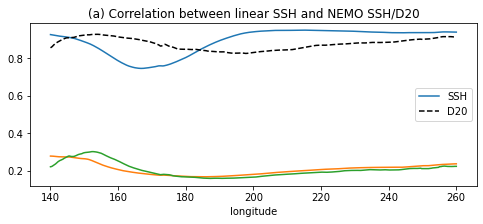

In [21]:
fig = plt.figure(figsize=(8,3))
corr_ssha_sshlia.plot(label='SSH')
corr_d20a_sshlia.plot(label='D20',color='black', linestyle='--')
corr_ssha_sshlia_up.plot()
corr_d20a_sshlia_up.plot()
plt.title('(a) Correlation between linear SSH and NEMO SSH/D20')
plt.xlabel('longitude');
plt.legend()

### 3. Fig4bcd: Create NTIs and test for FigS4

In [22]:
ssh_b = detrend(ssh_b.compute())
d20_b = detrend(d20_b.compute())
d20_c = -1*detrend(sshli_b.compute())
ssh_d = detrend(ssh_d.compute())
d20_d = -1*detrend(sshli_d.compute())

/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/mclaus/mambaforge/envs/nti/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

In [23]:
nti_nemo = standardize(ssh_b) + standardize(d20_b)
nti_nemolin = standardize(ssh_b) + standardize(d20_c)
nti_aviso = standardize(ssh_d) + standardize(d20_d)

In [24]:
corr_nti_nemo_nti_nemolin, corr_nti_nemo_nti_nemolin_up, corr_nti_nemo_nti_nemolin_low = corr_with_ttest(nti_nemo, nti_nemolin, sig=0.95)
corr_nti_nemolin_nti_aviso, corr_nti_nemolin_nti_aviso_up, corr_nti_nemolin_nti_aviso_low = corr_with_ttest(nti_nemolin, nti_aviso, sig=0.95)
corr_nti_aviso_nti_nemo, corr_nti_aviso_nti_nemo_up, corr_nti_aviso_nti_nemo_low = corr_with_ttest(nti_aviso, nti_nemo, sig=0.95)

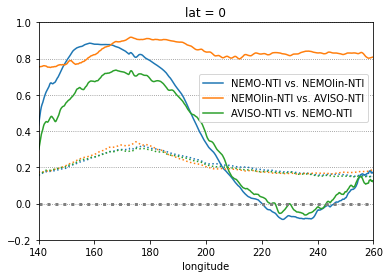

In [25]:
corr_nti_nemo_nti_nemolin.plot(label='NEMO-NTI vs. NEMOlin-NTI')
corr_nti_nemolin_nti_aviso.plot(label='NEMOlin-NTI vs. AVISO-NTI')
corr_nti_aviso_nti_nemo.plot(label='AVISO-NTI vs. NEMO-NTI')
corr_nti_nemo_nti_nemolin_up.plot(c='C0', ls=":")
corr_nti_nemolin_nti_aviso_up.plot(c='C1', ls=":")
corr_nti_aviso_nti_nemo_up.plot(c='C2', ls=":")
# rho1.plot(c='C0',ls=':')
# rho2.plot(c='C1',ls=':')
# rho3.plot(c='C2',ls=':')
plt.legend(loc=7,bbox_to_anchor=(1, 0.65))
plt.ylim(-0.2,1)
plt.xlim(140,260)
plt.ylabel("");
plt.xlabel('longitude');
plt.axhline(y=0., c="0.5", ls=":", lw=3)
plt.grid(color='grey',linestyle = ':',axis='y')

## Write output

In [26]:
!rm -rf data_fig4.zarr
xr.Dataset(
    dict(
        corr_ssha_sshlia=corr_ssha_sshlia,
        corr_d20a_sshlia=corr_d20a_sshlia,
        corr_ssha_sshlia_up=corr_ssha_sshlia_up,
        corr_d20a_sshlia_up=corr_d20a_sshlia_up,
        corr_ssha_sshlia_low=corr_ssha_sshlia_low,
        corr_d20a_sshlia_low=corr_d20a_sshlia_low,
        nti_nemo=nti_nemo,
        nti_nemolin=nti_nemolin,
        nti_aviso=nti_aviso
    )
).to_zarr("data_fig4.zarr");

In [27]:
!rm -rf data_fig4S.zarr
xr.Dataset(
    dict(
        nti_nemo_var=nti_nemo.var("time", ddof=1),
        nti_nemolin_var=nti_nemolin.var("time", ddof=1),
        nti_aviso_var=nti_aviso.var("time", ddof=1),
        corr_nti_nemo_nti_nemolin=corr_nti_nemo_nti_nemolin,
        corr_nti_nemolin_nti_aviso=corr_nti_nemolin_nti_aviso,
        corr_nti_aviso_nti_nemo=corr_nti_aviso_nti_nemo,
    )
).to_zarr("data_fig4S.zarr");